# Hit Track Prediction:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import matplotlib.pyplot as plt

from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# plotly.tools.set_credentials_file(username='mtfaye', api_key='N9PkbhoY5zxhbU3LKqtb'

In [2]:
#Load dataset from a local csv file
df = pd.read_csv('/Users/FayeFamilly/Desktop/hit-predictor/notebook/tracks.csv')

### Pre-processing

In [3]:
df.sample() 

,Unnamed: 0,index,duration_ms,name,popularity,track_number,acousticness,analysis_url,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
243,43,43,37640,raindrops (an angel cried),68,1,0.942,https://api.spotify.com/v1/audio-analysis/0v2L...,0.336,0.231,0.0,1,0.188,-6.217,1,0.0497,168.685,5,0.429


In [4]:
df.shape

(250, 19)

In [5]:
df.isnull().values.any()

False

In [6]:
# Drop non-numeric cols
df = df.drop(['Unnamed: 0', 'index', 'analysis_url', 'name','track_number'], axis=1)
df.sample(3)

,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
39,423640,27,0.8610,0.116,0.153,0.880000,9,0.109,-16.208,0,0.0400,88.320,3,0.0398
217,189533,72,0.0348,0.757,0.730,0.000062,7,0.136,-6.304,1,0.1870,90.013,4,0.4510
200,190440,89,0.0421,0.726,0.554,0.000000,5,0.106,-5.290,0,0.0917,169.999,4,0.3350


In [7]:
df.describe()

,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,228781.784000,45.920000,0.355375,0.638608,0.539925,0.116266,5.528000,0.184883,-7.900864,0.508000,0.133347,108.609816,3.876000,0.435319
std,60254.605318,27.525118,0.328555,0.218442,0.258938,0.271565,3.425808,0.128843,5.385447,0.500939,0.121634,27.095154,0.495587,0.244797
min,37640.000000,0.000000,0.000588,0.072800,0.053400,0.000000,0.000000,0.028000,-29.395000,0.000000,0.025600,51.403000,1.000000,0.036500
25%,194923.250000,27.000000,0.053300,0.500000,0.318500,0.000000,2.000000,0.106000,-10.215750,0.000000,0.039600,91.140500,4.000000,0.233000
50%,222326.500000,53.000000,0.221500,0.691000,0.572500,0.000007,6.000000,0.130000,-6.812500,1.000000,0.066950,101.011000,4.000000,0.430500
75%,266632.750000,68.000000,0.692000,0.802000,0.779250,0.003035,8.000000,0.236500,-4.122000,1.000000,0.215500,123.584750,4.000000,0.628000
max,503893.000000,90.000000,0.975000,0.947000,0.934000,0.938000,11.000000,0.681000,-0.362000,1.000000,0.471000,191.972000,5.000000,0.962000


In [8]:
# key and mode are categorical variables but we want to use them into our prediction model 
# lets use one-hot-encoding to convert them into numericals vars
dum = pd.get_dummies(df, columns=['key','mode'], drop_first=True)
dff = dum
dff.columns

Index(['duration_ms', 'popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'time_signature', 'valence', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1'],
      dtype='object')

## EDA

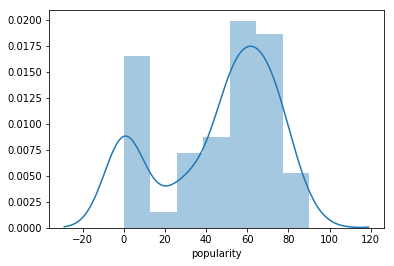

In [9]:
# Popularity distribution
sns.distplot(dff.popularity)

### Check correlations

Let's choose the inputs and outputs of our model: 
As the goal of this project is to predict the popularity of a song. The variable Popularity will be definitly our dependant variable. We will verify which audio feature have influence the most the popularity of a track.

See the following link for documentations:
https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/

In [10]:
# Between all attributes
dff.corr().style.format("{:.2}").background_gradient\
(cmap=plt.get_cmap('coolwarm'), axis=1)

,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,valence,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1
duration_ms,1.0,0.052,0.027,-0.21,-0.0085,0.11,0.083,-0.18,-0.02,-0.13,-0.062,-0.11,0.071,0.057,-0.13,-0.1,0.16,-0.04,-0.065,-0.058,0.069,-0.073,0.1,0.12
popularity,0.052,1.0,-0.49,0.4,0.55,-0.46,0.14,0.48,0.33,-0.0075,0.23,0.27,0.22,-0.1,-0.017,-0.14,-0.046,0.041,-0.017,0.032,0.012,-0.05,0.061,0.09
acousticness,0.027,-0.49,1.0,-0.64,-0.81,0.48,-0.27,-0.7,-0.39,-0.026,-0.22,-0.57,-0.22,0.035,0.051,0.11,0.18,-0.07,-0.1,-0.048,0.075,0.037,0.032,-0.22
danceability,-0.21,0.4,-0.64,1.0,0.66,-0.6,0.23,0.76,0.43,-0.11,0.22,0.75,0.13,-0.12,0.0064,0.0019,-0.1,0.053,0.0072,0.066,-0.11,0.042,0.005,0.1
energy,-0.0085,0.55,-0.81,0.66,1.0,-0.5,0.37,0.81,0.53,0.022,0.23,0.64,0.24,-0.067,0.016,-0.016,-0.17,0.039,0.05,0.009,-0.11,-0.062,0.044,0.12
instrumentalness,0.11,-0.46,0.48,-0.6,-0.5,1.0,-0.19,-0.53,-0.33,0.011,-0.23,-0.51,-0.16,0.15,-0.023,0.028,-0.025,-0.0075,-0.023,-0.0046,-0.0097,0.1,0.039,-0.12
liveness,0.083,0.14,-0.27,0.23,0.37,-0.19,1.0,0.27,0.28,0.029,0.033,0.33,0.13,0.045,0.0013,0.022,-0.13,-0.081,0.033,-0.028,-0.012,-0.062,0.065,0.013
loudness,-0.18,0.48,-0.7,0.76,0.81,-0.53,0.27,1.0,0.44,-0.064,0.24,0.63,0.22,-0.063,0.075,0.014,-0.21,0.097,0.0023,0.062,-0.096,-0.043,-0.0068,0.076
speechiness,-0.02,0.33,-0.39,0.43,0.53,-0.33,0.28,0.44,1.0,0.059,0.082,0.39,0.13,0.046,0.048,0.034,-0.051,0.04,-0.034,-0.14,-0.047,-0.0042,-0.012,0.028
tempo,-0.13,-0.0075,-0.026,-0.11,0.022,0.011,0.029,-0.064,0.059,1.0,0.071,-0.059,0.13,0.045,-0.024,-0.029,0.0052,-0.048,-0.01,0.00034,-0.089,-0.093,0.0037,0.025


In [11]:
# Verify the corr between the independant variables and dependant variable(popularity)
popular= dff.corr()['popularity'].sort_values()  
popular

acousticness       -0.490420
instrumentalness   -0.455569
key_4              -0.136077
key_2              -0.100791
key_10             -0.049542
key_5              -0.046421
key_3              -0.016633
key_7              -0.016603
tempo              -0.007475
key_9               0.011963
key_8               0.031742
key_6               0.041217
duration_ms         0.051878
key_11              0.061251
mode_1              0.089756
liveness            0.138586
key_1               0.216258
time_signature      0.225965
valence             0.268964
speechiness         0.330323
danceability        0.402352
loudness            0.482647
energy              0.545707
popularity          1.000000
Name: popularity, dtype: float64

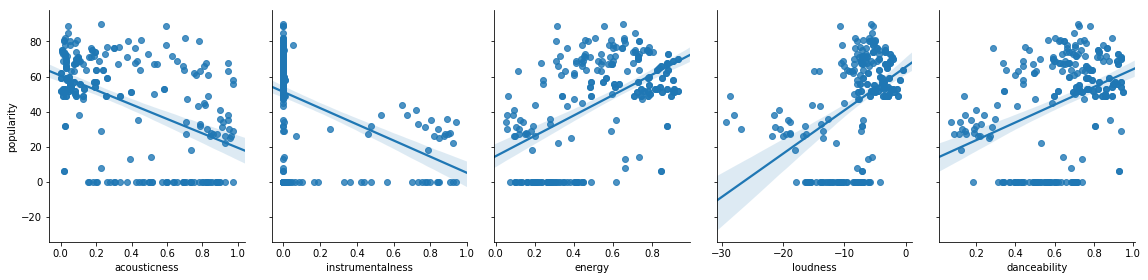

In [12]:
# Lets take a look at the vars that are correlated the most with the dependants var, popularity
sns.pairplot(dff,x_vars=['acousticness','instrumentalness','energy','loudness','danceability'],
             y_vars=['popularity'],
             height=4, aspect=.8, kind="reg")

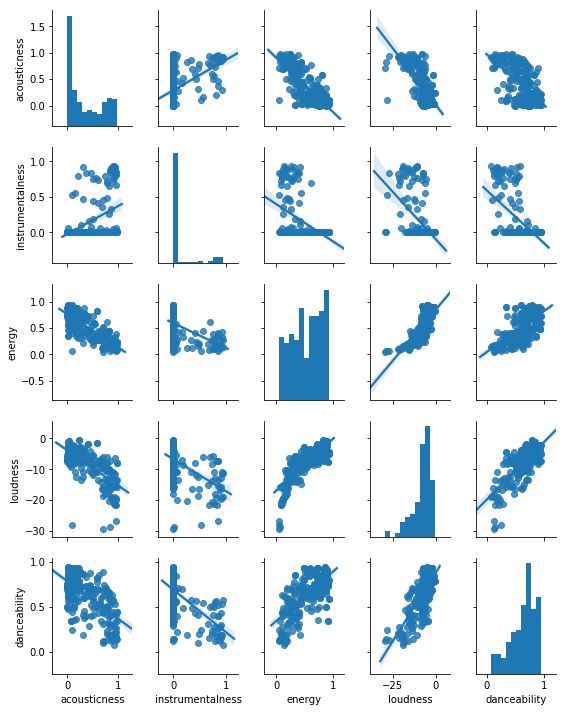

In [13]:
# Verify the existence of a multicollinearity between the potential features 
sns.pairplot(dff,x_vars=['acousticness','instrumentalness','energy','loudness','danceability'],
             y_vars=['acousticness','instrumentalness','energy','loudness','danceability'],
             height=2, aspect=.8, kind="reg")

### Let's now choose the features

In [14]:
# features 
X = dff.loc[:,['loudness',]]

In [15]:
# Dependant Variable
y = dff.popularity

### Model_1: Linear Regression

In [16]:
# Create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### fit a model

In [17]:
model = LinearRegression()

In [18]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
# Interpret the coefficient and the intercept
y_pred = model.predict(X_test)
model.coef_

array([2.72422118])

In [20]:
model.intercept_

67.45080408810216

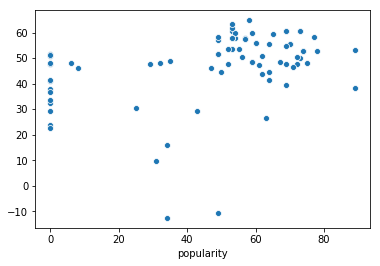

In [21]:
# The line / model
sns.scatterplot(y_test, y_pred)

In [22]:
model.score(X_test,y_test)

0.11322433106437768

 ### Model_2: Random Forest Regression

In [23]:
#Split data into training and test
